# Log prob function

In [1]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class GPTContainer:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2") # change to gpt-xl when running for real
        self.model = GPT2LMHeadModel.from_pretrained("gpt2").to(self.device) # change to gpt-xl when running for real
        
        self.starts = []
        self.suffs = []

        # Populate starts and suffs
        for i in range(len(self.tokenizer.get_vocab())):
            tok = self.tokenizer.decode(i)
            if tok[0] == " " or tok[0] == ".":
                self.starts.append(i)
            elif tok[0] != " ":
                self.suffs.append(i)
                    
    def gpt2_sent_prob(self, sent):
        logsoftmax = torch.nn.LogSoftmax(dim=-1)
        
        tokenizer = self.tokenizer
        model = self.model

        starts = self.starts
        suffs = self.suffs

        sent = ". " + sent + "."

        tokens = tokenizer.encode(sent)
        inputs = torch.tensor(tokens).to(self.device)

        with torch.no_grad():
            out = model(inputs)

        unsoft = out[0]
        lab1 = inputs.cpu().data.numpy()
        
        probs = []
        for x in range(len(lab1) - 1):

            lab = lab1[x + 1]
            unsoft1 = unsoft[x]

            if lab in starts:

                soft = logsoftmax(unsoft1[starts])
                prob = float(soft[starts.index(lab)].cpu().data.numpy())

            elif lab in suffs:

                soft = logsoftmax(unsoft1[suffs])
                prob = float(soft[suffs.index(lab)].cpu().data.numpy())

            probs.append(prob)

        prob = np.sum(probs)

        return prob


# Example usage

In [3]:
gpt = GPTContainer()

In [4]:
sentence = "A message has been sent to your account"
log_probability = gpt.gpt2_sent_prob(sentence)

# Creating log probabilities

In [5]:
dfsentence = pd.read_csv("our_df.csv", usecols=['sentence_pair', 'sentence1','sentence2','trial_type','subject','cluster','subjects_majority_vote_2clusters',  'subject_selected_sentence' ,'gpt_choice', 'include_as_gpt_item','gpt_engaged_subjects_agreement', 'subject_chose_majority_2clusters','agreement_2clusters'])
dfsentence = dfsentence[(dfsentence['include_as_gpt_item'] == True) & (dfsentence['cluster'].isin(['engaged_accurate', 'engaged_struggling']))]
dfsentence.reset_index(drop=True, inplace=True)

In [6]:
# # dfsentence = df.drop_duplicates(subset='sentence_pair')
# dfsentence[['sentence1', 'sentence2']] = dfsentence['sentence_pair'].str.split('_', expand=True)

In [7]:
# Calculate probabilities for each pair of sentences
probabilities = []
for index, row in dfsentence.iterrows():

    prob1 = gpt.gpt2_sent_prob(row['sentence1'])
    prob2 = gpt.gpt2_sent_prob(row['sentence2'])
    probabilities.append([prob1, prob2])

# Add probabilities to the DataFrame
dfsentence['probability_sentence1'] = [p[0] for p in probabilities]
dfsentence['probability_sentence2'] = [p[1] for p in probabilities]

In [8]:
# Push df to csv
dfsentence.to_csv('our_sentences_probs.csv', index=False)

# Revisioned version

In [9]:
class GPTContainer:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2") # change to gpt-xl when running for real
        self.model = GPT2LMHeadModel.from_pretrained("gpt2").to(self.device) # change to gpt-xl when running for real

                    
    def gpt2_sent_prob(self, sent):
        logsoftmax = torch.nn.LogSoftmax(dim=-1)
        
        tokenizer = self.tokenizer
        model = self.model

        sent = ". " + sent + "."

        tokens = tokenizer.encode(sent)
        inputs = torch.tensor(tokens).to(self.device)

        with torch.no_grad():
            out = model(inputs)

        unsoft = out[0]
        lab1 = inputs.cpu().data.numpy()
        
        probs = []
        for x in range(1, len(lab1) - 1):

            lab = lab1[x + 1]
            unsoft1 = unsoft[x]

            soft = logsoftmax(unsoft1)
            prob = float(soft[lab].cpu().data.numpy())
            probs.append(prob)
            print(prob)

        prob = np.sum(probs)

        return prob

In [10]:
gpt = GPTContainer()

In [11]:
sentence = "A message has been sent to your account"
gpt.gpt2_sent_prob(sentence)

-7.239984512329102
-4.573660373687744
-0.29312607645988464
-0.8000895380973816
-0.511279821395874
-4.366835594177246
-3.6869876384735107
-1.5026687383651733


-22.974632292985916

In [12]:
# Calculate probabilities for each pair of sentences
probabilities = []
for index, row in dfsentence.iterrows():
    prob1 = gpt.gpt2_sent_prob(row['sentence1'])
    prob2 = gpt.gpt2_sent_prob(row['sentence2'])
    probabilities.append([prob1, prob2])

# Add probabilities to the DataFrame
dfsentence['probability_sentence1'] = [p[0] for p in probabilities]
dfsentence['probability_sentence2'] = [p[1] for p in probabilities]

-7.239984512329102
-4.573660373687744
-0.29312607645988464
-0.8000895380973816
-0.511279821395874
-4.366835594177246
-3.6869876384735107
-1.5026687383651733
-2.2901270389556885
-8.436443328857422
-3.335456609725952
-0.007888591848313808
-5.289908409118652
-12.2411527633667
-8.849669456481934
-0.9288944602012634
-4.610692501068115
-7.454982757568359
-6.807912826538086
-1.620871663093567
-5.743642807006836
-0.6594749689102173
-4.666686058044434
-2.066805601119995
-1.2704354524612427
-6.174628734588623
-5.4421305656433105
-2.5838541984558105
-6.428377151489258
-0.6308457851409912
-2.6011252403259277
-5.196628093719482
-1.6485786437988281
-4.610692501068115
-4.148105621337891
-10.71666431427002
-6.515083312988281
-2.862046241760254
-11.948721885681152
-7.412616729736328
-7.547116279602051
-3.625760793685913
-3.278038501739502
-11.082038879394531
-2.0730042457580566
-3.858436107635498
-8.9225435256958
-2.534160614013672
-5.82510232925415
-1.5366597175598145
-3.7554569244384766
-2.6377720832

In [13]:
# Push df to csv
dfsentence.to_csv('our_sentences_probs_revised.csv', index=False)

# Calculating differences between models

In [18]:
dforiginal = pd.read_csv('our_sentences_probs.csv')
dfrevised = pd.read_csv('our_sentences_probs_revised.csv')

In [19]:
dforiginal.columns

Index(['sentence_pair', 'sentence1', 'sentence2', 'trial_type', 'subject',
       'subject_selected_sentence', 'cluster',
       'subjects_majority_vote_2clusters', 'subject_chose_majority_2clusters',
       'agreement_2clusters', 'include_as_gpt_item', 'gpt_choice',
       'gpt_engaged_subjects_agreement', 'probability_sentence1',
       'probability_sentence2'],
      dtype='object')

In [20]:
dforiginal['selection'] = None
dfrevised['selection'] = None

# Iterate over each row in dforiginal
for index, row in dforiginal.iterrows():
    prob1_orig = row['probability_sentence1']
    prob2_orig = row['probability_sentence2']
    
    # Get the corresponding row from dfrevised
    row_revised = dfrevised.iloc[index]
    prob1_revised = row_revised['probability_sentence1']
    prob2_revised = row_revised['probability_sentence2']
    
    # Calculate the absolute differences for the original DataFrame
    diff1_orig = abs(0 - prob1_orig)
    diff2_orig = abs(0 - prob2_orig)
    
    # Calculate the absolute differences for the revised DataFrame
    diff1_revised = abs(0 - prob1_revised)
    diff2_revised = abs(0 - prob2_revised)
    
    # Compare the differences for both DataFrames
    if diff1_orig < diff2_orig:
        dforiginal.at[index, 'selection'] = 1
    else:
        dforiginal.at[index, 'selection'] = 2
    
    if diff1_revised < diff2_revised:
        dfrevised.at[index, 'selection'] = 1
    else:
        dfrevised.at[index, 'selection'] = 2

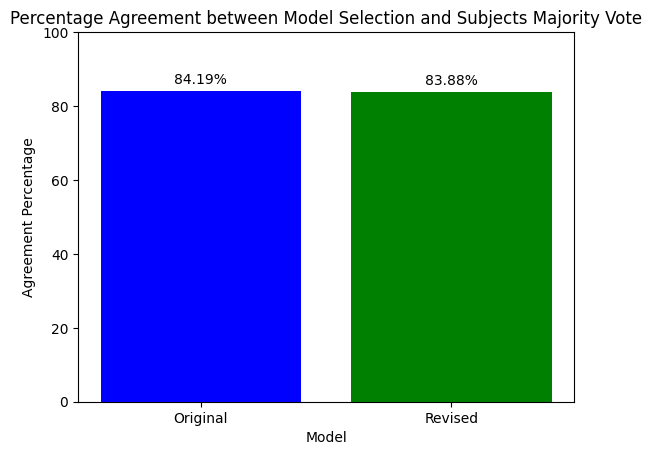

In [21]:
# Compute agreement percentage for original DataFrame
original_agreement = (dforiginal['selection'] == dforiginal['subjects_majority_vote_2clusters']).mean() * 100

# Compute agreement percentage for revised DataFrame
revised_agreement = (dfrevised['selection'] == dfrevised['subjects_majority_vote_2clusters']).mean() * 100

# Plot the agreement percentages as a bar plot
plt.bar(['Original', 'Revised'], [original_agreement, revised_agreement], color=['blue', 'green'])
plt.title('Percentage Agreement between Model Selection and Subjects Majority Vote')
plt.xlabel('Model')
plt.ylabel('Agreement Percentage')
plt.ylim(0, 100)

for i, v in enumerate([original_agreement, revised_agreement]):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom')

# Show plot
plt.show()